In [1]:
#Imports
import numpy as np
import pandas as pd
import os as os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix

#Setting seed for reproducability purposes
SEED = 123
tf.random.set_seed(SEED)


In [2]:
#Associating train, test, and validation dataset with variables
train_imgs = '.\\Face Mask Dataset\\Train'
test_imgs = '.\\Face Mask Dataset\\Test'
validation_imgs = '.\\Face Mask Dataset\\Validation'

#Creating variables for train with & without mask datasets
train_withoutMask_imgs = os.path.join(train_imgs, 'WithoutMask')
train_withMask_imgs = os.path.join(train_imgs, 'WithMask')

#Printing names of images in datasets to assure variable paths are correct
train_withoutMask_names = os.listdir(train_withoutMask_imgs)
print(train_withoutMask_names[0:10])

train_withMask_names = os.listdir(train_withMask_imgs)
print(train_withMask_names[0:10])


['10.png', '100.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1009.png', '101.png', '1010.png']
['10.png', '100.png', '1004.png', '1005.png', '1006.png', '1007.png', '1008.png', '1011.png', '1012.png', '1018.png']


['.\\Face Mask Dataset\\Train\\WithoutMask\\10.png', '.\\Face Mask Dataset\\Train\\WithoutMask\\100.png', '.\\Face Mask Dataset\\Train\\WithoutMask\\1004.png', '.\\Face Mask Dataset\\Train\\WithoutMask\\1005.png', '.\\Face Mask Dataset\\Train\\WithoutMask\\1006.png']


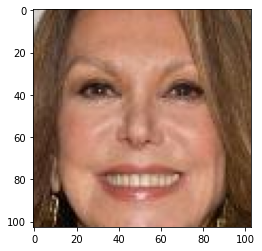

['.\\Face Mask Dataset\\Train\\WithMask\\10.png', '.\\Face Mask Dataset\\Train\\WithMask\\100.png', '.\\Face Mask Dataset\\Train\\WithMask\\1004.png', '.\\Face Mask Dataset\\Train\\WithMask\\1005.png', '.\\Face Mask Dataset\\Train\\WithMask\\1006.png']


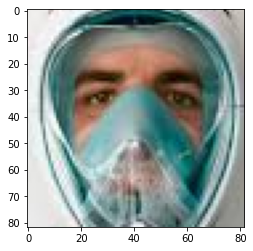

In [3]:
#Creating array of dirs for train images without mask
train_withoutMask_img_dirs = []
for m in train_withoutMask_names:
    train_withoutMask_img_dirs.append(os.path.join(train_withoutMask_imgs, m))
print(train_withoutMask_img_dirs[0:5])

#Display first img in maskless dataset
without_mask_img = mpimg.imread(train_withoutMask_img_dirs[0])
plt.imshow(without_mask_img)
plt.show()

#Creating array of names for train images with mask
train_withMask_img_dirs = []
for m in train_withMask_names:
    train_withMask_img_dirs.append(os.path.join(train_withMask_imgs, m))
print(train_withMask_img_dirs[0:5])

#Display first img in masked dataset
with_mask_img = mpimg.imread(train_withMask_img_dirs[0])
plt.imshow(with_mask_img)
plt.show()

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


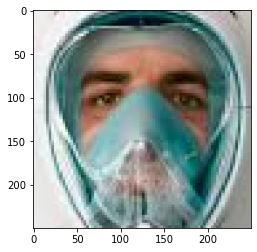

In [4]:
#Specifying batch size hyperparamter
batch_size = 80

#Intitalize ImagDataGenerators for train, test, and validation
train_img_gen = ImageDataGenerator(
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1./255
)
test_img_gen = ImageDataGenerator(
    rescale=1./255
)
val_img_gen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_img_gen.flow_from_directory(
    directory = train_imgs,
    target_size=(250,250),
    batch_size=batch_size,
    class_mode='binary',
    seed = SEED,
    shuffle=False
)

test_gen = test_img_gen.flow_from_directory(
    test_imgs,
    target_size=(250,250),
    batch_size=batch_size,
    class_mode='binary',
    seed = SEED,
    shuffle=False
)

val_gen = val_img_gen.flow_from_directory(
    validation_imgs,
    target_size=(250,250),
    batch_size=batch_size,
    class_mode='binary',
    seed = SEED,
    shuffle=False
)

#Creating image plot from training image data generator
for i, element in enumerate(train_gen):
    plt.imshow(element[0][i])
    plt.show()
    break

In [5]:
#Printing out classes and shape of for each data generator
img_shape = train_gen.image_shape
print("Training Data Generator")
print("classes: ", train_gen.class_indices)
print("image shape: ", img_shape)

Training Data Generator
classes:  {'WithMask': 0, 'WithoutMask': 1}
image shape:  (250, 250, 3)


In [6]:
#Specifying model layers
model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3,input_shape=(250,250,3), activation="relu", name="Conv2D_Layer_1"),
    layers.MaxPooling2D(pool_size=2, name="MaxPooling_Layer_1"),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", name="Conv2D_Layer_2"),
    layers.MaxPooling2D(pool_size=2, name="MaxPooling_Layer_2"),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", name="Conv2D_Layer_3"),
    layers.MaxPooling2D(pool_size=2, name="MaxPooling_Layer_3"),
    layers.Flatten(name="Flatten_Layer"),
    layers.Dense(512, activation="relu", name="Dense_Layer_1" ),
    layers.Dense(1, activation="sigmoid", name="Dense_Layer_2")
])

#Printing Model Summary
print(model.summary())

#Initializing optmizer for model compilation
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#defining loss for model compilation
loss = "binary_crossentropy"

#Defining metrics for model compilation
metrics = ["accuracy"]

#Compiling the model using optimizer above
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_Layer_1 (Conv2D)      (None, 248, 248, 32)      896       
_________________________________________________________________
MaxPooling_Layer_1 (MaxPooli (None, 124, 124, 32)      0         
_________________________________________________________________
Conv2D_Layer_2 (Conv2D)      (None, 122, 122, 64)      18496     
_________________________________________________________________
MaxPooling_Layer_2 (MaxPooli (None, 61, 61, 64)        0         
_________________________________________________________________
Conv2D_Layer_3 (Conv2D)      (None, 59, 59, 128)       73856     
_________________________________________________________________
MaxPooling_Layer_3 (MaxPooli (None, 29, 29, 128)       0         
_________________________________________________________________
Flatten_Layer (Flatten)      (None, 107648)            0

In [7]:
#Defining Callbacks 
#Initializing Early Stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

#Initializing Model Checkopoint
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath='./models',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only = False
)

#Initialize Tensorboard
tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs'
)

#Initialize ReduceLROnPlateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.01,
    patience=3,
    min_lr=1e-5
)

#fitting model with training and validation generators
train_model= model.fit(
    train_gen,
    epochs=6,
    validation_data=val_gen,
    batch_size=batch_size,
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard]
)

Epoch 1/6
  1/125 [..............................] - ETA: 0s - loss: 0.7224 - accuracy: 0.0500WARNING:tensorflow:From C:\Users\PhantomMenace\.conda\envs\csi4106\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
125/125 [==============================] - ETA: 0s - loss: 0.7793 - accuracy: 0.5917WARNING:tensorflow:From C:\Users\PhantomMenace\.conda\envs\csi4106\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets writt

In [8]:
train_metrics = pd.DataFrame(model.history.history)
print(train_metrics.head())

       loss  accuracy  val_loss  val_accuracy      lr
0  0.779294    0.5917  0.616017       0.51625  0.0001
1  0.376300    0.8690  0.183901       0.94375  0.0001
2  0.158217    0.9459  0.117161       0.95875  0.0001
3  0.106448    0.9626  0.138928       0.94875  0.0001
4  0.094620    0.9671  0.088671       0.97125  0.0001


In [9]:
#Evaluate trained model against test generator
test_evals = model.evaluate(test_gen)

#Printing test loss and accuracy returned by evaluation
print("\n")
print("test loss: ", test_evals[0] )
print("test accuracy: ", test_evals[1] )

13/13 [==============================] - 9s 716ms/step - loss: 0.0844 - accuracy: 0.9718


test loss:  0.08437388390302658
test accuracy:  0.9717742204666138


In [10]:
#Run prediction from model against test gen
prediction = model.predict(test_gen)

#Round prediction data to 1s and 0s
flatten_pred = prediction.flatten()
predicted_lbls = np.where(flatten_pred > 0.5, 1, 0)

#Print classification report comparing labels to predicted labels
cr = classification_report(test_gen.labels, predicted_lbls)
print(cr)

#Print confusion matrix comparing labels to predicted labels
cm = confusion_matrix(test_gen.labels, predicted_lbls)
print(cm)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       483
           1       0.95      0.99      0.97       509

    accuracy                           0.97       992
   macro avg       0.97      0.97      0.97       992
weighted avg       0.97      0.97      0.97       992

[[458  25]
 [  3 506]]
